In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve

## Set up network

In [3]:
## Parameters

task_type='Iris_classification'

Nin: int = 2
Ninter: int = 8
Nout: int = 2


# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.02  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

R_update: str = 'propto'
# R_update = 'deltaR'

# training length
iterations = 600  # number of sampled of p
    
supress_prints: bool = False
bc_noise: float = 0.0
use_p_tag: bool = True
# use_p_tag: bool = False
    
M_values: np.ndarray = array([0.4, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])
    
## Networkx sizes
scale: float = 5.0
squish: float = 0.01

In [4]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         Nout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         supress_prints, \
                         bc_noise, \
                         task_type, \
                         M_values, \
                         Ninter)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)

mismatched # of inputs and outputs for Iris classification. correcting accordingly to Nin=4 Nout=3
alpha_vec [0.02 0.02 0.02]


In [5]:
## Assign input and output nodes a.f.o lattice size and row choice
input_nodes_arr, inter_nodes_arr, output_nodes_arr, ground_nodes_arr = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.Ninter, Variabs.Nout)

In [6]:
print('input_nodes_arr ', input_nodes_arr)
print('inter_nodes_arr ', inter_nodes_arr)
print('output_nodes_arr ', output_nodes_arr)
print('ground_nodes_arr ', ground_nodes_arr)

input_nodes_arr  [0 1 2 3]
inter_nodes_arr  [ 4  5  6  7  8  9 10 11]
output_nodes_arr  [12 13 14]
ground_nodes_arr  [15]


In [7]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [8]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(input_nodes_arr, \
                           output_nodes_arr, \
                           inter_nodes_arr, \
                           ground_nodes_arr,)
Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [9]:
## Initiate internal flow network state class

State = Network_State(Variabs.Nin, Variabs.Nout)
State.initiate_resistances(BigClass)
BigClass.add_State(State)  # add to big class

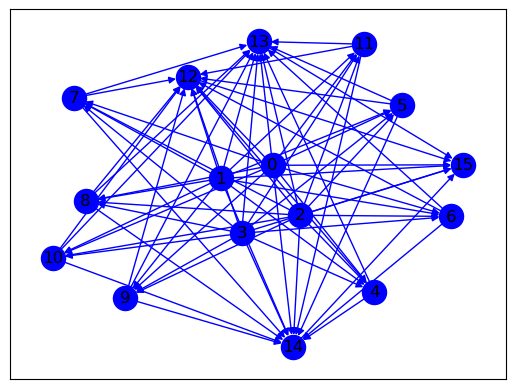

NET is ready


In [10]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
BigClass.add_NET(NET)  # add to big class

## Train

In [11]:
for i in range(Variabs.iterations):
    print('i', i)
    State.draw_p_in_and_desired(Variabs, i)
    print('p_drawn ', State.input_drawn)
    print('desired output', State.desired)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    print('output meausred', State.output)
    if not i % 2:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.calc_loss(BigClass)
        State.update_pressure_dual(BigClass)
        State.update_output_dual(BigClass)
        State.solve_flow_given_problem(BigClass, "dual")  # measure and don't change resistances
        State.update_Rs(BigClass)

i 0
p_drawn  [2.         1.33333333 2.50847458 1.83333333]
desired output [0. 1. 0.]
output meausred [1.7183152 1.7183152 1.7183152]
i 1
p_drawn  [1.55555556 3.         0.47457627 0.33333333]
desired output [1. 0. 0.]
output meausred [1.20077578 1.20077578 1.20077578]
loss= [[-0.20077578 -1.20077578 -1.20077578]
 [-1.7183152  -0.7183152  -1.7183152 ]]
time= 1
input_dual_nxt= [1.01380105 0.94824606 1.06315735 1.04657855]
output_dual_nxt [0.48429227 0.50499385 0.49464306]
i 2
p_drawn  [3.77777778 1.         4.         3.66666667]
desired output [0. 0. 1.]
output meausred [2.66651319 2.6799864  2.67340429]
i 3
p_drawn  [1.88888889 1.5        2.37288136 2.33333333]
desired output [0. 1. 0.]
output meausred [1.80821995 1.81801038 1.81321374]
loss= [[-1.80821995 -0.81801038 -1.81321374]
 [-2.66651319 -2.6799864  -1.67340429]]
time= 2
input_dual_nxt= [1.11128509 0.92244146 1.14713164 1.11539081]
output_dual_nxt [0.46955892 0.47289427 0.49704831]
i 4
p_drawn  [2.77777778 1.33333333 2.57627119 

output meausred [0.55715274 0.29903312 0.73140123]
loss= [[-0.55715274  0.70096688 -0.73140123]
 [-0.76915482  0.58669464 -1.00825893]]
time= 62
input_dual_nxt= [2.19957896 2.57871957 1.70171887 1.82229505]
output_dual_nxt [0.14183541 0.05849705 0.23348716]
i 124
p_drawn  [1.11111111 2.83333333 0.33898305 0.16666667]
desired output [1. 0. 0.]
output meausred [0.90813477 0.49029869 1.18455796]
i 125
p_drawn  [1.44444444 1.66666667 2.10169492 2.        ]
desired output [0. 1. 0.]
output meausred [0.75365119 0.40519946 0.98805872]
loss= [[-0.75365119  0.59480054 -0.98805872]
 [ 0.09186523 -0.49029869 -1.18455796]]
time= 63
input_dual_nxt= [2.19667175 2.58889481 1.68634513 1.80630537]
output_dual_nxt [0.14444777 0.05665023 0.23271492]
i 126
p_drawn  [3.33333333 1.5        3.59322034 2.83333333]
desired output [0. 0. 1.]
output meausred [0.90601077 0.46866175 1.17587305]
i 127
p_drawn  [2.66666667 2.16666667 3.18644068 3.33333333]
desired output [0. 0. 1.]
output meausred [1.08156614 0.5602

C:\Users\SMR_Admin\OneDrive - huji.ac.il\PhD\Network Simulation repo\Network combine\Network_combine\matrix_functions.py:151: RuntimeWarning: divide by zero encountered in divide
  K_vec: NDArray[np.float_] = 1/R_vec


output meausred [0.91429759 0.39127797 1.15659519]
loss= [[ 0.08570241 -0.39127797 -1.15659519]
 [-0.65121087  0.72308575 -0.82810754]]
time= 76
input_dual_nxt= [2.31905959 2.79557199 1.65896426 1.81701768]
output_dual_nxt [0.13860811 0.04030191 0.20132452]
i 152
p_drawn  [3.77777778 1.         4.         3.66666667]
desired output [0. 0. 1.]
output meausred [0.80683516 0.31850492 1.00520231]
i 153
p_drawn  [1.88888889 1.5        2.37288136 2.33333333]
desired output [0. 1. 0.]
output meausred [0.7226046  0.28647226 0.89761768]
loss= [[-0.7226046   0.71352774 -0.89761768]
 [-0.80683516 -0.31850492 -0.00520231]]
time= 77
input_dual_nxt= [2.32751606 2.79333351 1.6662488  1.82298696]
output_dual_nxt [0.13846621 0.03964074 0.20324473]
i 154
p_drawn  [2.77777778 1.33333333 2.57627119 2.16666667]
desired output [0. 1. 0.]
output meausred [0.71132908 0.27802598 0.88911307]
i 155
p_drawn  [1.22222222 2.33333333 0.33898305 0.5       ]
desired output [1. 0. 0.]
output meausred [0.72964682 0.2872

output meausred [0.34848682 0.05657517 0.58384632]
i 259
p_drawn  [2.         1.5        2.50847458 2.16666667]
desired output [0. 1. 0.]
output meausred [0.4304191  0.06957835 0.72529967]
loss= [[-0.4304191   0.93042165 -0.72529967]
 [ 0.65151318 -0.05657517 -0.58384632]]
time= 130
input_dual_nxt= [2.84765632 3.41789699 2.00256937 2.25034881]
output_dual_nxt [0.07879703 0.01075271 0.16845327]
i 260
p_drawn  [2.44444444 1.33333333 2.44067797 2.33333333]
desired output [0. 1. 0.]
output meausred [0.40769772 0.06860663 0.69835771]
i 261
p_drawn  [2.11111111 1.33333333 2.57627119 2.83333333]
desired output [0. 0. 1.]
output meausred [0.41847906 0.07039976 0.71712875]
loss= [[-0.41847906 -0.07039976  0.28287125]
 [-0.40769772  0.93139337 -0.69835771]]
time= 131
input_dual_nxt= [2.84744735 3.41789699 2.00265437 2.25066227]
output_dual_nxt [0.0787947  0.01071679 0.16882165]
i 262
p_drawn  [3.         2.         2.50847458 2.16666667]
desired output [0. 1. 0.]
output meausred [0.52461309 0.08

loss= [[-0.32028746  0.94099669 -0.6138609 ]
 [ 0.63922382 -0.06664419 -0.68806076]]
time= 148
input_dual_nxt= [2.93189546 3.50006002 2.0723096  2.33525989]
output_dual_nxt [0.06703037 0.01012196 0.16067226]
i 296
p_drawn  [0.66666667 0.83333333 2.37288136 2.66666667]
desired output [0. 0. 1.]
output meausred [0.25367154 0.04554899 0.48272029]
i 297
p_drawn  [1.66666667 3.33333333 0.13559322 0.16666667]
desired output [1. 0. 0.]
output meausred [0.50250152 0.09065484 0.94834858]
loss= [[ 0.49749848 -0.09065484 -0.94834858]
 [-0.25367154 -0.04554899  0.51727971]]
time= 149
input_dual_nxt= [2.94708674 3.53803822 2.03832232 2.29728168]
output_dual_nxt [0.07076865 0.01008127 0.1470235 ]
i 298
p_drawn  [1.66666667 1.         2.03389831 1.83333333]
desired output [0. 1. 0.]
output meausred [0.27908602 0.0477877  0.47908635]
i 299
p_drawn  [3.11111111 1.66666667 3.3220339  3.33333333]
desired output [0. 0. 1.]
output meausred [0.47657862 0.08160236 0.81813031]
loss= [[-0.47657862 -0.08160236 

output meausred [0.43913169 0.02852188 0.88777133]
i 405
p_drawn  [0.33333333 2.33333333 0.27118644 0.33333333]
desired output [1. 0. 0.]
output meausred [0.27874643 0.01815623 0.56088402]
loss= [[ 0.72125357 -0.01815623 -0.56088402]
 [-0.43913169 -0.02852188  0.11222867]]
time= 203
input_dual_nxt= [3.30607485 3.96204992 2.25767219 2.5807406 ]
output_dual_nxt [0.05468716 0.00324181 0.1492272 ]
i 406
p_drawn  [2.77777778 1.66666667 3.05084746 3.33333333]
desired output [0. 0. 1.]
output meausred [0.34017847 0.02333149 0.74356018]
i 407
p_drawn  [2.22222222 2.16666667 3.38983051 4.        ]
desired output [0. 0. 1.]
output meausred [0.40449183 0.02774832 0.88377813]
loss= [[-0.40449183 -0.02774832  0.11622187]
 [-0.34017847 -0.02333149  0.25643982]]
time= 204
input_dual_nxt= [3.3037532  3.9641394  2.25908878 2.58352658]
output_dual_nxt [0.05460444 0.00324142 0.14883397]
i 408
p_drawn  [0.44444444 2.         0.20338983 0.16666667]
desired output [1. 0. 0.]
output meausred [0.22501361 0.01

i 450
p_drawn  [2.         1.33333333 2.50847458 1.83333333]
desired output [0. 1. 0.]
output meausred [0.22950114 0.01578102 0.51938362]
i 451
p_drawn  [1.55555556 3.         0.47457627 0.33333333]
desired output [1. 0. 0.]
output meausred [0.31980438 0.02204313 0.72029068]
loss= [[ 0.68019562 -0.02204313 -0.72029068]
 [-0.22950114  0.98421898 -0.51938362]]
time= 226
input_dual_nxt= [3.39376859 4.06730457 2.29367216 2.6304599 ]
output_dual_nxt [0.05113598 0.00286206 0.13709957]
i 452
p_drawn  [3.77777778 1.         4.         3.66666667]
desired output [0. 0. 1.]
output meausred [0.28681018 0.01834286 0.62992839]
i 453
p_drawn  [1.88888889 1.5        2.37288136 2.33333333]
desired output [0. 1. 0.]
output meausred [0.2568429  0.01645015 0.56258899]
loss= [[-0.2568429   0.98354985 -0.56258899]
 [-0.28681018 -0.01834286  0.37007161]]
time= 227
input_dual_nxt= [3.39751612 4.06631258 2.29690035 2.63310522]
output_dual_nxt [0.05111802 0.00282414 0.13835566]
i 454
p_drawn  [2.77777778 1.333

loss= [[ 0.77273251 -0.00712106 -0.5091749 ]
 [-0.25096097 -0.00783841  0.43438763]]
time= 269
input_dual_nxt= [3.58204306 4.34748449 2.39317821 2.76742823]
output_dual_nxt [0.04903088 0.00136223 0.13619634]
i 538
p_drawn  [0.77777778 2.5        0.40677966 0.83333333]
desired output [1. 0. 0.]
output meausred [0.25182578 0.00795637 0.57260173]
i 539
p_drawn  [1.77777778 2.         2.57627119 2.83333333]
desired output [0. 1. 0.]
output meausred [0.28990378 0.00914185 0.66162229]
loss= [[-0.28990378  0.99085815 -0.66162229]
 [ 0.74817422 -0.00795637 -0.57260173]]
time= 270
input_dual_nxt= [3.58460874 4.34620165 2.39874443 2.77255959]
output_dual_nxt [0.04824032 0.00138591 0.13603785]
i 540
p_drawn  [0.88888889 0.83333333 1.3559322  1.66666667]
desired output [0. 1. 0.]
output meausred [0.13327045 0.00433476 0.308549  ]
i 541
p_drawn  [2.88888889 2.         3.18644068 3.66666667]
desired output [0. 0. 1.]
output meausred [0.32246231 0.01048937 0.74643272]
loss= [[-0.32246231 -0.01048937 

output meausred [0.16099313 0.00561672 0.48246665]
loss= [[-0.16099313  0.99438328 -0.48246665]
 [ 0.81974784 -0.00629811 -0.53773757]]
time= 298
input_dual_nxt= [3.73083092 4.44376473 2.52653521 2.9194099 ]
output_dual_nxt [0.03797079 0.00117876 0.14187216]
i 596
p_drawn  [0.66666667 0.83333333 2.37288136 2.66666667]
desired output [0. 0. 1.]
output meausred [0.1279592  0.00436979 0.38086299]
i 597
p_drawn  [1.66666667 3.33333333 0.13559322 0.16666667]
desired output [1. 0. 0.]
output meausred [0.25079093 0.00858662 0.7407735 ]
loss= [[ 0.74920907 -0.00858662 -0.7407735 ]
 [-0.1279592  -0.00436979  0.61913701]]
time= 299
input_dual_nxt= [3.7405701  4.46811268 2.50474585 2.89506195]
output_dual_nxt [0.04012567 0.0011784  0.13208324]
i 598
p_drawn  [1.66666667 1.         2.03389831 1.83333333]
desired output [0. 1. 0.]
output meausred [0.14118157 0.00458699 0.37902458]
i 599
p_drawn  [3.11111111 1.66666667 3.3220339  3.33333333]
desired output [0. 0. 1.]
output meausred [0.24101623 0.00

## Plots

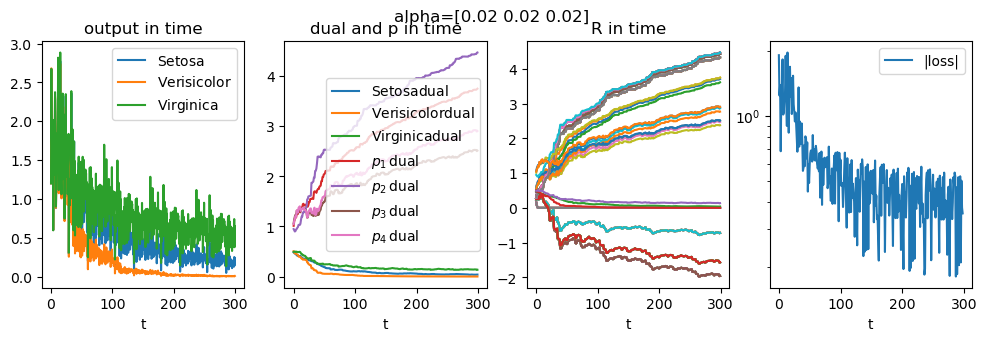

In [12]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M)
else:
        plot_functions.plot_importants(State, Variabs, State.desired_in_t)

## Statistics

In [13]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

final_err 1.164916272620018


## Checks

In [14]:
i = -inf

NameError: name 'inf' is not defined

In [ ]:
i % np.shape(Variabs.dataset)[0]